# **Price Range Forecast of House: DNN, CNN, LSTM**

In [1]:
import os
import datetime
import random

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import copy
import math
import pprint

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = True

# Create Dataset
1. Used customer's house browsing history to predict price range of house that customer will click on next.

2. Adopted k-means algorithm to explore the raw data first.

3. Four data fields are proposed, including information such as browsing history, location, house age and size, to represent the house types and price range that customers are interested in.

In [3]:
infile = open('/content/sale.csv','rb')
sale = pd.read_csv(infile)
infile1 = open('/content/shop.csv','rb')
shop = pd.read_csv(infile1)
infile2 = open('/content/search.csv','rb')
search = pd.read_csv(infile2)

## k-means

In [ ]:
infile3 = open('/content/kmeans_data.xlsx','rb')
kmeans = pd.read_excel(infile3)
del kmeans['Unnamed: 0']
data = copy.deepcopy(kmeans[450:])

In [6]:
for i in ['std', 'high_percentage', 'low_percentage', 'medium_percentage']:
  std = data[i].std()
  mean = data[i].mean()
  data[i] = (data[i] - mean)/std

In [7]:
from sklearn.cluster import KMeans
from sklearn import metrics

def kmeans_cluster(data, column_name):
  x = data[column_name]
  kmeans = KMeans(n_clusters=2, random_state=0).fit(x)
  silhouette_score.append(metrics.silhouette_score(x, kmeans.labels_, metric='euclidean'))
  return kmeans.labels_

In [8]:
column = [['std', 'high_percentage', 'low_percentage'],
          ['high_percentage', 'low_percentage', 'care_num'],
          ['std', 'high_percentage', 'low_percentage', 'care_num'], 
          ['std', 'high_percentage', 'low_percentage', 'care_num', 'medium_percentage'], 
          ['std', 'high_percentage', 'low_percentage', 'medium_percentage'], 
          ['high_percentage', 'low_percentage', 'medium_percentage'], 
          ['high_percentage', 'low_percentage', 'care_num', 'medium_percentage']] 
y_cluster = []
silhouette_score = []
for column_name in column:
  y_cluster.append(kmeans_cluster(data, column_name))

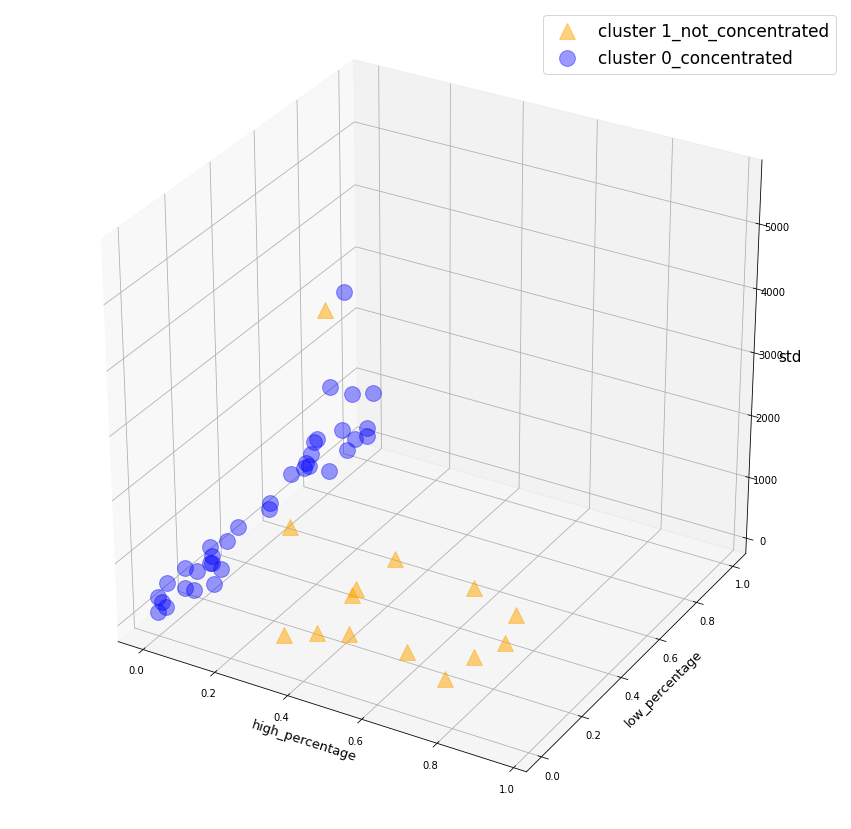

In [10]:
x = np.array(kmeans[450:]['high_percentage'])
y = np.array(kmeans[450:]['low_percentage'])
z = np.array(kmeans[450:]['std'])
result = y_cluster[0]

plt.figure(figsize=(15,15)) 
ax = plt.subplot(projection='3d')

for i in range(result.shape[0]):
  if result[i] == 1: 
    cluster1 = ax.scatter(x[i],y[i],z[i],color='orange', marker='^', alpha=0.5, s=250) 
  else: 
    cluster2 = ax.scatter(x[i],y[i],z[i],color='blue', marker='o', alpha=0.4, s=250)
    
ax.set_xlabel('high_percentage',fontsize=13)
ax.set_ylabel('low_percentage',fontsize=13)
ax.set_zlabel('std',fontsize=15)
ax.tick_params(axis='x',labelsize=10)
ax.tick_params(axis='y',labelsize=10)
ax.tick_params(axis='z',labelsize=10)
ax.legend((cluster1,cluster2),['cluster 1_not_concentrated','cluster 0_concentrated'],prop = {'size':17})
plt.savefig('kmeans.png')
plt.show()


In [11]:
data_after_kmeans = copy.deepcopy(kmeans[450:])
data_after_kmeans['cluster'] = result

result_cluster_mean = {'cluster1':[], 'cluster0':[]}
for i in range(2):
  tmp = data_after_kmeans[data_after_kmeans['cluster'] == i]
  result_cluster_mean['cluster'+str(i)] = [tmp['std'].mean(), tmp['high_percentage'].mean(),tmp['medium_percentage'].mean(), tmp['low_percentage'].mean(), tmp['care_num'].mean()]

result_final = pd.DataFrame(result_cluster_mean, index=['std_mean','high_percentage_mean', 'medium_percentage_mean', 'low_percentage_mean', 'care_num_mean']).T
result_final

,std_mean,high_percentage_mean,medium_percentage_mean,low_percentage_mean,care_num_mean
cluster1,1480.884313,0.627706,0.351074,0.021220,0.357143
cluster0,751.368654,0.043790,0.527027,0.429183,0.694444


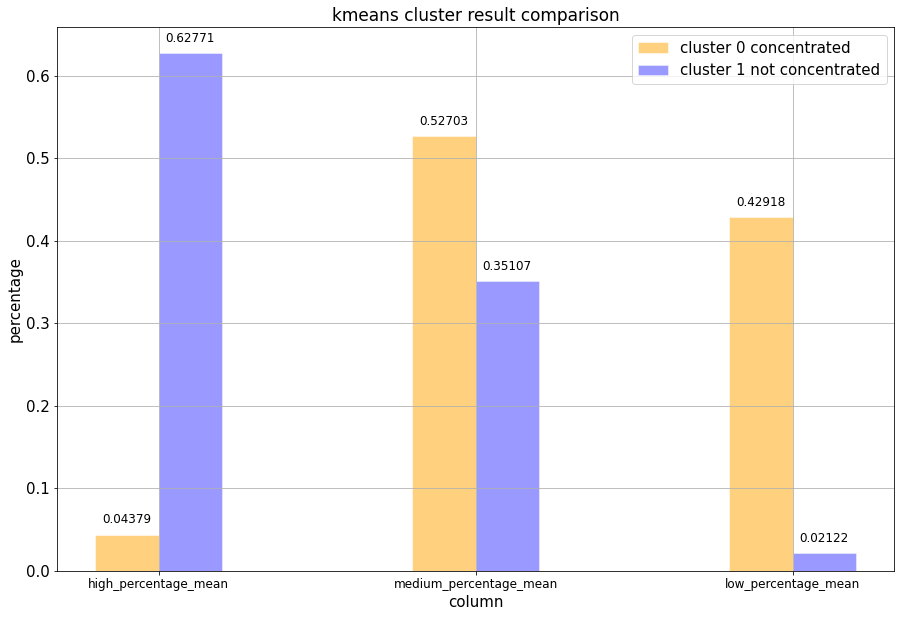

In [12]:
cluster_0 = result_cluster_mean['cluster0'][1:4]
cluster_1 = result_cluster_mean['cluster1'][1:4]

plt.figure(figsize=(15,10))
column_name = ['high_percentage_mean', 'medium_percentage_mean', 'low_percentage_mean']

index = [0,1,2]
bar_width = 0.2
plt.bar(index, cluster_0, bar_width, facecolor='orange', alpha = 0.5, edgecolor='white', label = 'cluster 0 concentrated')
plt.bar([0.2,1.2,2.2], cluster_1, bar_width, facecolor='blue', alpha=0.4, edgecolor='white', label = 'cluster 1 not concentrated')

plt.title('kmeans cluster result comparison',fontsize = 17)
plt.xticks([0.1, 1.1, 2.1], column_name, fontsize=12)
plt.yticks(fontsize=15)
plt.xlabel('column', fontsize=15)
plt.ylabel('percentage',fontsize=15)
plt.grid(True)
for a,b in zip(index, cluster_0):
  plt.text(a, b+0.01, '%.05f' % b, ha='center', va= 'bottom',fontsize=12)
for a,b in zip([0.2,1.2,2.2], cluster_1):
  plt.text(a, b+0.01, '%.05f' % b, ha='center', va= 'bottom',fontsize=12)

plt.legend(prop = {'size':15})
plt.savefig('cluster_comparison.png')

## Data Preprocessing

In [ ]:
shop = shop[['XE_DAY', 'memberid', '停車位', '刊登價格', '屋齡', '建物登記坪數', '房／廳／衛／室', '樓別', '樓高', '物件路段', '物件類型', '行政區']]
sale['成交日'] = pd.to_datetime(sale['成交日'])
shop['XE_DAY'] = pd.to_datetime(shop['XE_DAY'])

In [ ]:
shop['房／廳／衛／室'] = shop['房／廳／衛／室'].apply(lambda x:x.split('/'))
new_column = ['房','廳','衛','室']
for i in range(len(new_column)):
  shop[new_column[i]] = shop['房／廳／衛／室'].apply(lambda x:x[i]).astype(float)
shop['行政區'] = shop['行政區'].apply(lambda x: x.strip())
shop['物件路段'] = shop['物件路段'].apply(lambda x: x.strip())
del shop['房／廳／衛／室']
shop['停車位'] = shop['停車位'].apply(lambda x:1 if x == '有' else 0)

In [15]:
column_mean = {}
def calculate_mean(df, column_name):
  alist = list(df[column_name].unique())
  for i in alist:
    column_mean[i] = df[df[column_name]==i]['刊登價格'].mean()
calculate_mean(shop, '物件路段')
calculate_mean(shop, '物件類型')
calculate_mean(shop, '行政區')

In [16]:
shop['物件路段_mean'] = shop['物件路段'].apply(lambda x:column_mean[x])
shop['物件類型_mean'] = shop['物件類型'].apply(lambda x:column_mean[x])
shop['行政區_mean'] = shop['行政區'].apply(lambda x:column_mean[x])

In [17]:
member = list(shop.memberid.unique())
member_row = {}
for i in member:
  tmp = shop[shop['memberid'] == i]
  member_row[i] = [shop[shop['memberid']==i].shape[0],tmp['刊登價格'].mean(),	tmp['屋齡'].mean(),	tmp['建物登記坪數'].mean(), tmp['房'].mean(), tmp['廳'].mean(),	tmp['衛'].mean(), tmp['室'].mean()]

In [18]:
shop['物件路段_mean_diff'] = (shop['刊登價格'] - shop['物件路段_mean'])/shop['物件路段_mean']
shop['物件類型_mean_diff'] = (shop['刊登價格'] - shop['物件類型_mean'])/shop['物件類型_mean']
shop['行政區_mean_diff'] = (shop['刊登價格'] - shop['行政區_mean'])/shop['行政區_mean']

In [19]:
mean_diff = {}
for i in ['刊登價格','屋齡','建物登記坪數','房','廳','衛']:
  mean_diff[i] = []
for i in range(shop.shape[0]):
  id = shop.iloc[i,1]
  mean_diff['刊登價格'].append((shop.iloc[i]['刊登價格'] - member_row[id][1])/ member_row[id][1])
  mean_diff['屋齡'].append((shop.iloc[i]['屋齡'] - member_row[id][2])/ member_row[id][2])
  mean_diff['建物登記坪數'].append((shop.iloc[i]['建物登記坪數'] - member_row[id][3])/ member_row[id][3])
  mean_diff['房'].append((shop.iloc[i]['房'] - member_row[id][4])/ member_row[id][4])
  mean_diff['廳'].append((shop.iloc[i]['廳'] - member_row[id][5])/ member_row[id][5])
  mean_diff['衛'].append((shop.iloc[i]['衛'] - member_row[id][6])/ member_row[id][6])

for i in ['刊登價格','屋齡','建物登記坪數','房','廳','衛']:
  shop[i+'_mean_diff'] = mean_diff[i]

In [20]:
def input_data(df, id):
  tmp = df[df['memberid'] == id]
  tmp = tmp.sort_values(by=['XE_DAY'])
  day_diff = []  
  for i in range(tmp.shape[0]):
    if i != (tmp.shape[0] - 1):
      day_diff.append((tmp.iloc[i+1]['XE_DAY'] - tmp.iloc[i]['XE_DAY']).days)
    else:
      day_diff.append(np.mean(day_diff))
  tmp['day_diff'] = day_diff
  return tmp[['停車位', '刊登價格', '屋齡', '建物登記坪數', '樓別', '樓高', '房', '廳', '衛', '室', 
              '物件路段_mean_diff', '物件類型_mean_diff', '行政區_mean_diff', '刊登價格_mean_diff',
              '屋齡_mean_diff', '建物登記坪數_mean_diff', '房_mean_diff', '廳_mean_diff', '衛_mean_diff', 'day_diff']]

# Build models & Predict
1. Forecast house price range of next click based on the data of customers' previous two clicks.

2. Models: multi-step dense model(deep neural network), convolutional neural network, long short-term memory

3. Used custom error rate and accuracy rate to evaluate models' predictive ability. Error rate: the difference between the real price and the predicted price of next click expressed in percentage. Accuracy rate: the ratio of the real price of next click falling within the predicted price range.
 

## Training process

In [21]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None):
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.label_columns = label_columns
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
    
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.total_window_size = input_width + label_width

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
     
  def __repr__(self):
    return '\n'.join([f'Total window size: {self.total_window_size}', f'Input indices: {self.input_indices}',
                      f'Label indices: {self.label_indices}', f'Label column name(s): {self.label_columns}'])
    
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels


  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data, targets=None, sequence_length=self.total_window_size,\
                                                              sequence_stride=1, shuffle=False,batch_size=32)
    ds = ds.map(self.split_window)
    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

In [22]:
window_width = 2
multi_step_dense_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])])

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=(window_width,), activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)])

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(units=1)])

In [23]:
max_epochs = 30

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
  model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
  history = model.fit(window.train, epochs=max_epochs, validation_data=window.val, callbacks=[early_stopping])
  return history


def training_process(id):
  if 'conv' in model_name:
    model = conv_model
  elif 'multi_step_dense' in model_name:
    model = multi_step_dense_model
  elif 'lstm' in model_name:
    model = lstm_model

  history = compile_and_fit(model, window)
  performance[id]['validation'][model_name] = model.evaluate(window.val)
  performance[id]['test'][model_name] = model.evaluate(window.test, verbose=0)
  tmp = model.predict(window.test)
  y_pred = tmp.reshape(tmp.shape[0])*train_std['刊登價格']+train_mean['刊登價格']
  return y_pred

In [ ]:
random_seed = 514
tf.random.set_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

all_y = {}
performance = {}

for i in member:
  if member_row[i][0] >= 1000:
    performance[i] = {'validation':{},'test':{}}
    all_y[i] = {'y_true':[], 'y_pred':{}}
    df = input_data(shop, i)
    column_indices = {name: i for i, name in enumerate(df.columns)}
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    num_features = df.shape[1]
    train_mean = train_df.mean()
    train_std = train_df.std()
    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std

    window = WindowGenerator(input_width = window_width, label_width = 1, shift=1, train_df = train_df, val_df = val_df, test_df = test_df, label_columns = ['刊登價格'])

    for j in ['conv_model','multi_step_dense_model','lstm']:
      model_name = j
      y_pred = training_process(i)
      all_y[i]['y_pred'][model_name] = y_pred
    y_true = np.array(test_df[window_width:]['刊登價格']*train_std['刊登價格']+train_mean['刊登價格'])
    all_y[i]['y_true'] = y_true


## models' performance

### Error Rate

In [25]:
member_used = list(performance.keys())
error_rate = {}
for i in member_used:
  error_rate[i] = abs((all_y[i]['y_pred']['lstm'] - all_y[i]['y_true'])/all_y[i]['y_pred']['lstm'])
  
average_error_rate = [np.mean(error_rate[i]) for i in member_used]
member_result = sorted(zip(average_error_rate, member_used), key=lambda x: x[0])

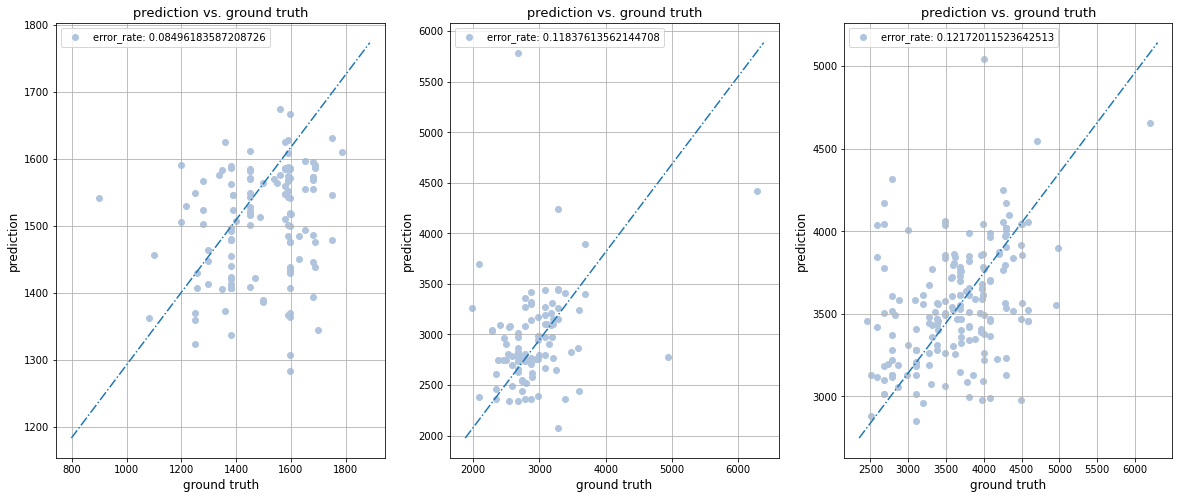

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20,8))
for i in range(3):
  id = member_result[i][1]
  ax[i].scatter(all_y[id]['y_true'], all_y[id]['y_pred']['lstm'], facecolor='lightsteelblue')
  ax[i].set_title('prediction vs. ground truth',fontsize = 13)
  ax[i].set_xlabel('ground truth',fontsize=12)
  ax[i].set_ylabel('prediction',fontsize=12) 
  ax[i].legend(['error_rate: ' + str(member_result[i][0])])
  ax[i].plot([int(min(all_y[id]['y_true']-100)),int(max(all_y[id]['y_true']+100))], [int(min(all_y[id]['y_pred']['lstm']-100)),int(max(all_y[id]['y_pred']['lstm']+100))],linestyle='-.')
plt.savefig('pred_truth_top3.png')

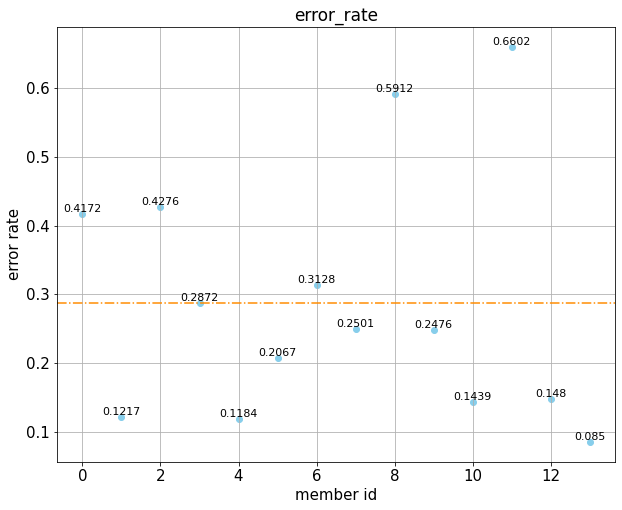

In [ ]:
plt.figure(figsize=(10,8))

for i in (range(len(average_error_rate))):
  plt.scatter(i, average_error_rate[i], facecolor='skyblue')
  plt.text(i, average_error_rate[i], round(average_error_rate[i],4), ha='center', va= 'bottom',fontsize=11)
  plt.grid()

plt.title('error_rate',fontsize = 17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('member id',fontsize=15)
plt.ylabel('error rate',fontsize=15)

plt.axhline(y=np.mean(np.array(member_result)[:,0]), color='darkorange', linestyle='-.')
plt.savefig('error_rate.png')

### Accuracy Rate

In [26]:
def accuracy(error_rate, y_pred, y_true):
  count = 0
  tmp_high = []
  tmp_low = []
  for i in range(1, len(y_pred)):
    error = np.mean(error_rate[:i])
    high = y_pred[i]*(1+error)
    low = y_pred[i]*(1-error)
    if low <0:
      low = 0
    if y_true[i] >= low and y_true[i] <= high:
      count += 1
    tmp_high.append(high)
    tmp_low.append(low)
  return tmp_high, tmp_low, count/(len(y_pred)-1)

In [27]:
accuracy_rate = {}
high_low = {}
for i in member_used:
  high_low[i] = {}
  high_low[i]['high'], high_low[i]['low'], accuracy_rate1 = accuracy(error_rate[i], all_y[i]['y_pred']['lstm'], all_y[i]['y_true'])
  accuracy_rate[i] = accuracy_rate1

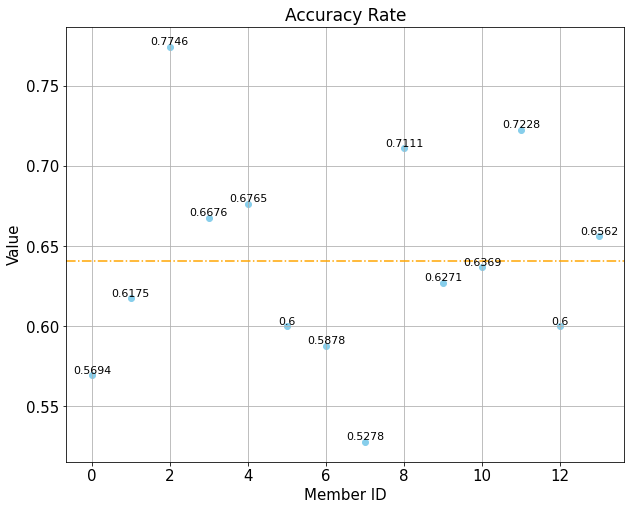

In [ ]:
plt.figure(figsize=(10,8))
accuracy_list = list(accuracy_rate.values())
for i in (range(len(accuracy_rate))):
  tmp_value = accuracy_list[i]
  plt.scatter(i, tmp_value, facecolor='skyblue')
  plt.text(i, tmp_value, round(tmp_value, 4), ha='center', va= 'bottom',fontsize=11)
  plt.grid()

plt.title('Accuracy Rate',fontsize = 17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Member ID',fontsize=15)
plt.ylabel('Value',fontsize=15)

plt.axhline(y=np.mean(accuracy_list), color='orange', linestyle='-.')
plt.savefig('accuracy_rate.png')

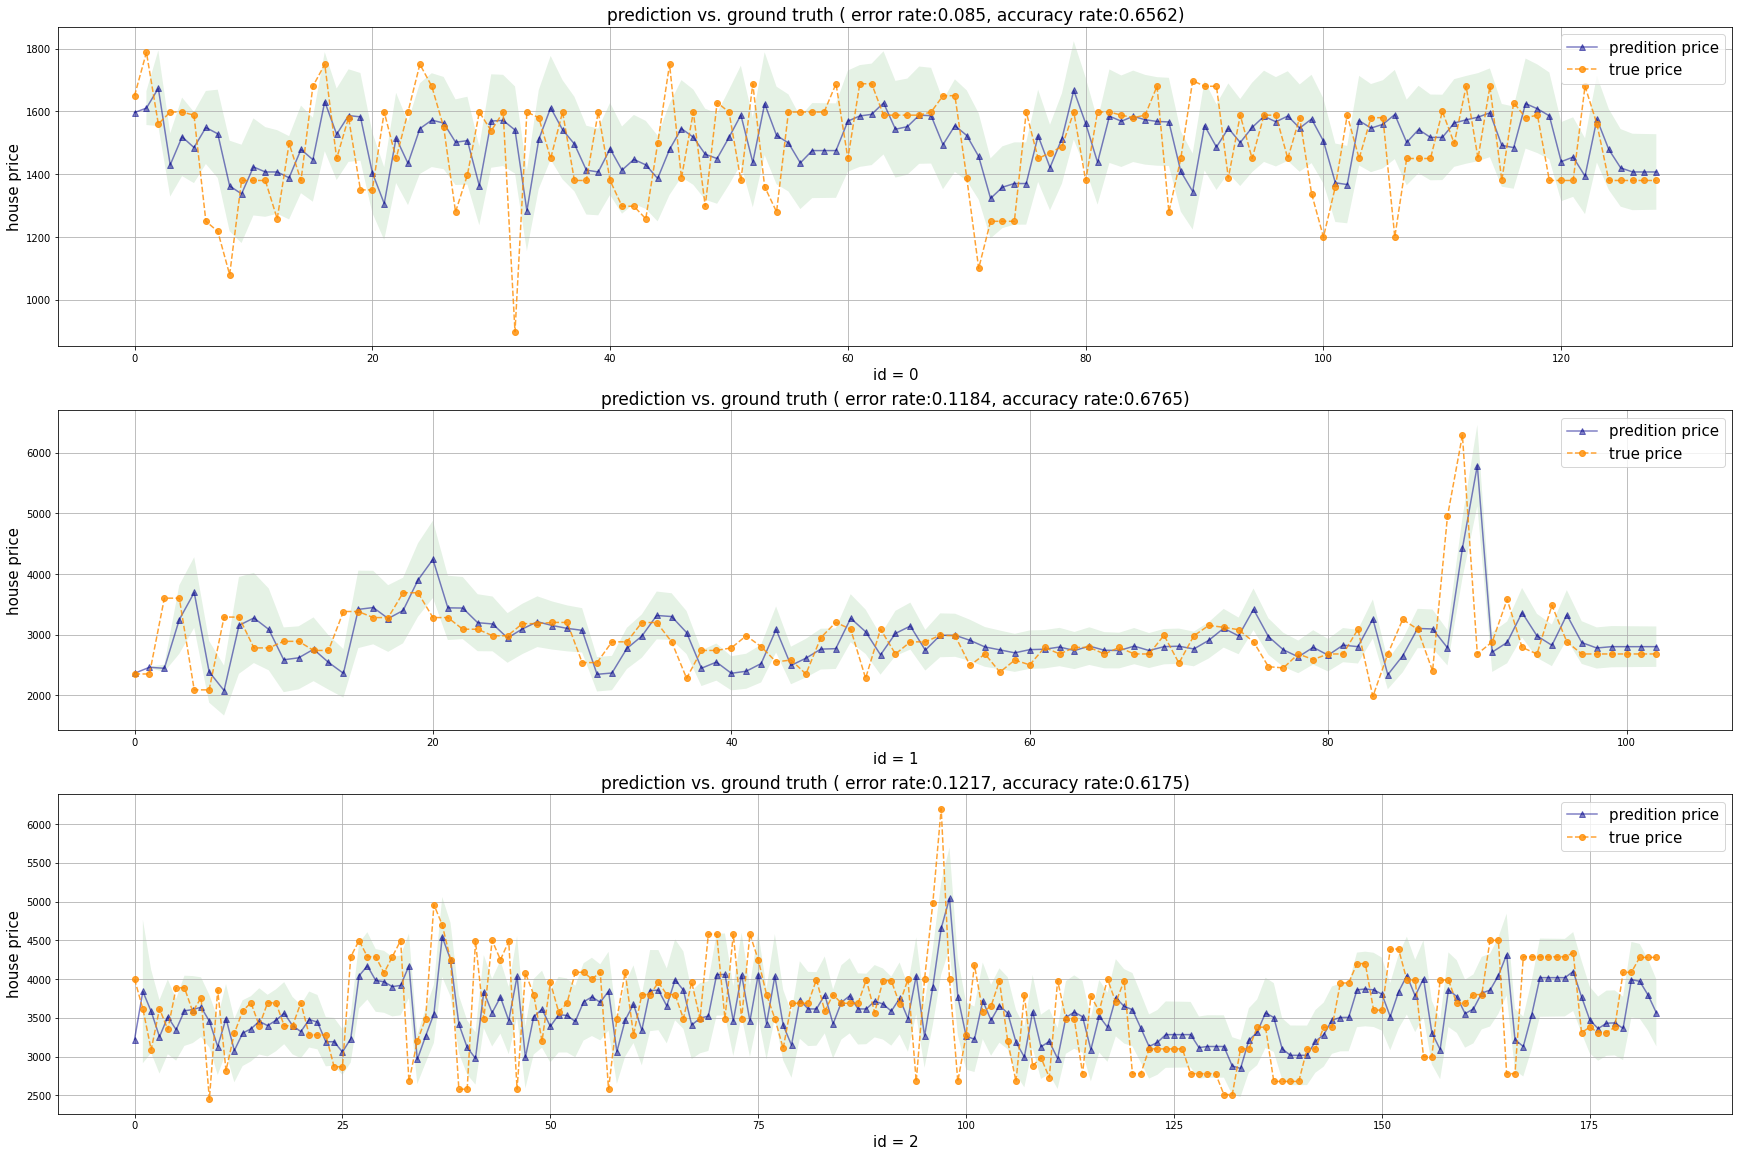

In [29]:
fig, ax = plt.subplots(ncols=1, nrows=3,figsize=(30,20))
for i in range(3):
  id = member_result[i][1]
  ax[i].plot(range(len(all_y[id]['y_true'])), all_y[id]['y_pred']['lstm'],'^-', color='darkblue',alpha=0.5)
  ax[i].plot(range(len(all_y[id]['y_true'])), all_y[id]['y_true'],'o--', color='darkorange',alpha=0.8)
  ax[i].set_title('prediction vs. ground truth ( error rate:'+ str(round(member_result[i][0],4))+', accuracy rate:'+str(round(accuracy_rate[id], 4))+')',fontsize = 17)
  ax[i].set_ylabel('house price',fontsize=15) 
  ax[i].set_xlabel('id = '+str(i),fontsize=15)
  ax[i].legend(['predition price','true price'],fontsize=15) 
  ax[i].fill_between(range(1, len(all_y[id]['y_true'])),high_low[id]['low'],high_low[id]['high'],facecolor='green',alpha=0.1)


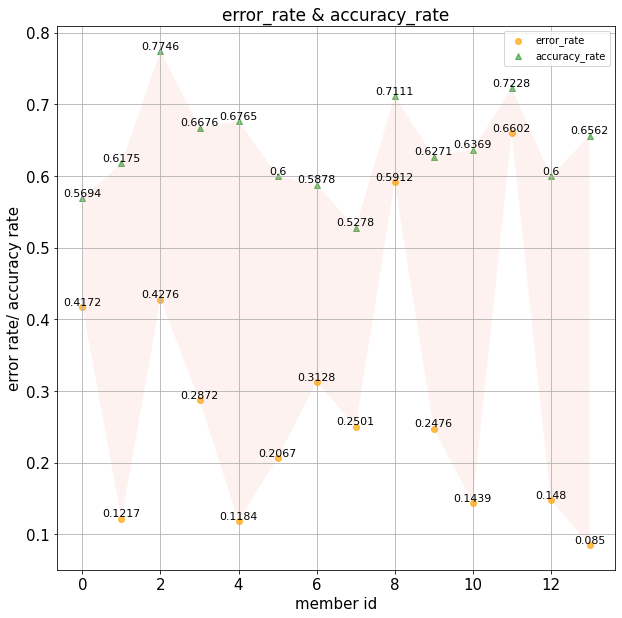

In [ ]:
plt.figure(figsize=(10,10))

for i in (range(len(average_error_rate))):
  plt.scatter(i, average_error_rate[i], facecolor='orange',alpha=0.7)
  plt.scatter(i, accuracy_list[i], marker='^', facecolor='green', alpha=0.5)
  plt.text(i, accuracy_list[i], round(accuracy_list[i],4), ha='center', va= 'bottom',fontsize=11)
  plt.text(i, average_error_rate[i], round(average_error_rate[i], 4), ha='center', va= 'bottom',fontsize=11)
  plt.grid()

plt.title('error_rate & accuracy_rate',fontsize = 17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('member id',fontsize=15)
plt.ylabel('error rate/ accuracy rate',fontsize=15)
plt.legend(['error_rate', 'accuracy_rate'])
plt.fill_between(range(len(accuracy_rate)), average_error_rate, list(accuracy_rate.values()),facecolor='salmon',alpha=0.1)
plt.savefig('error_accuracy_rate.png')

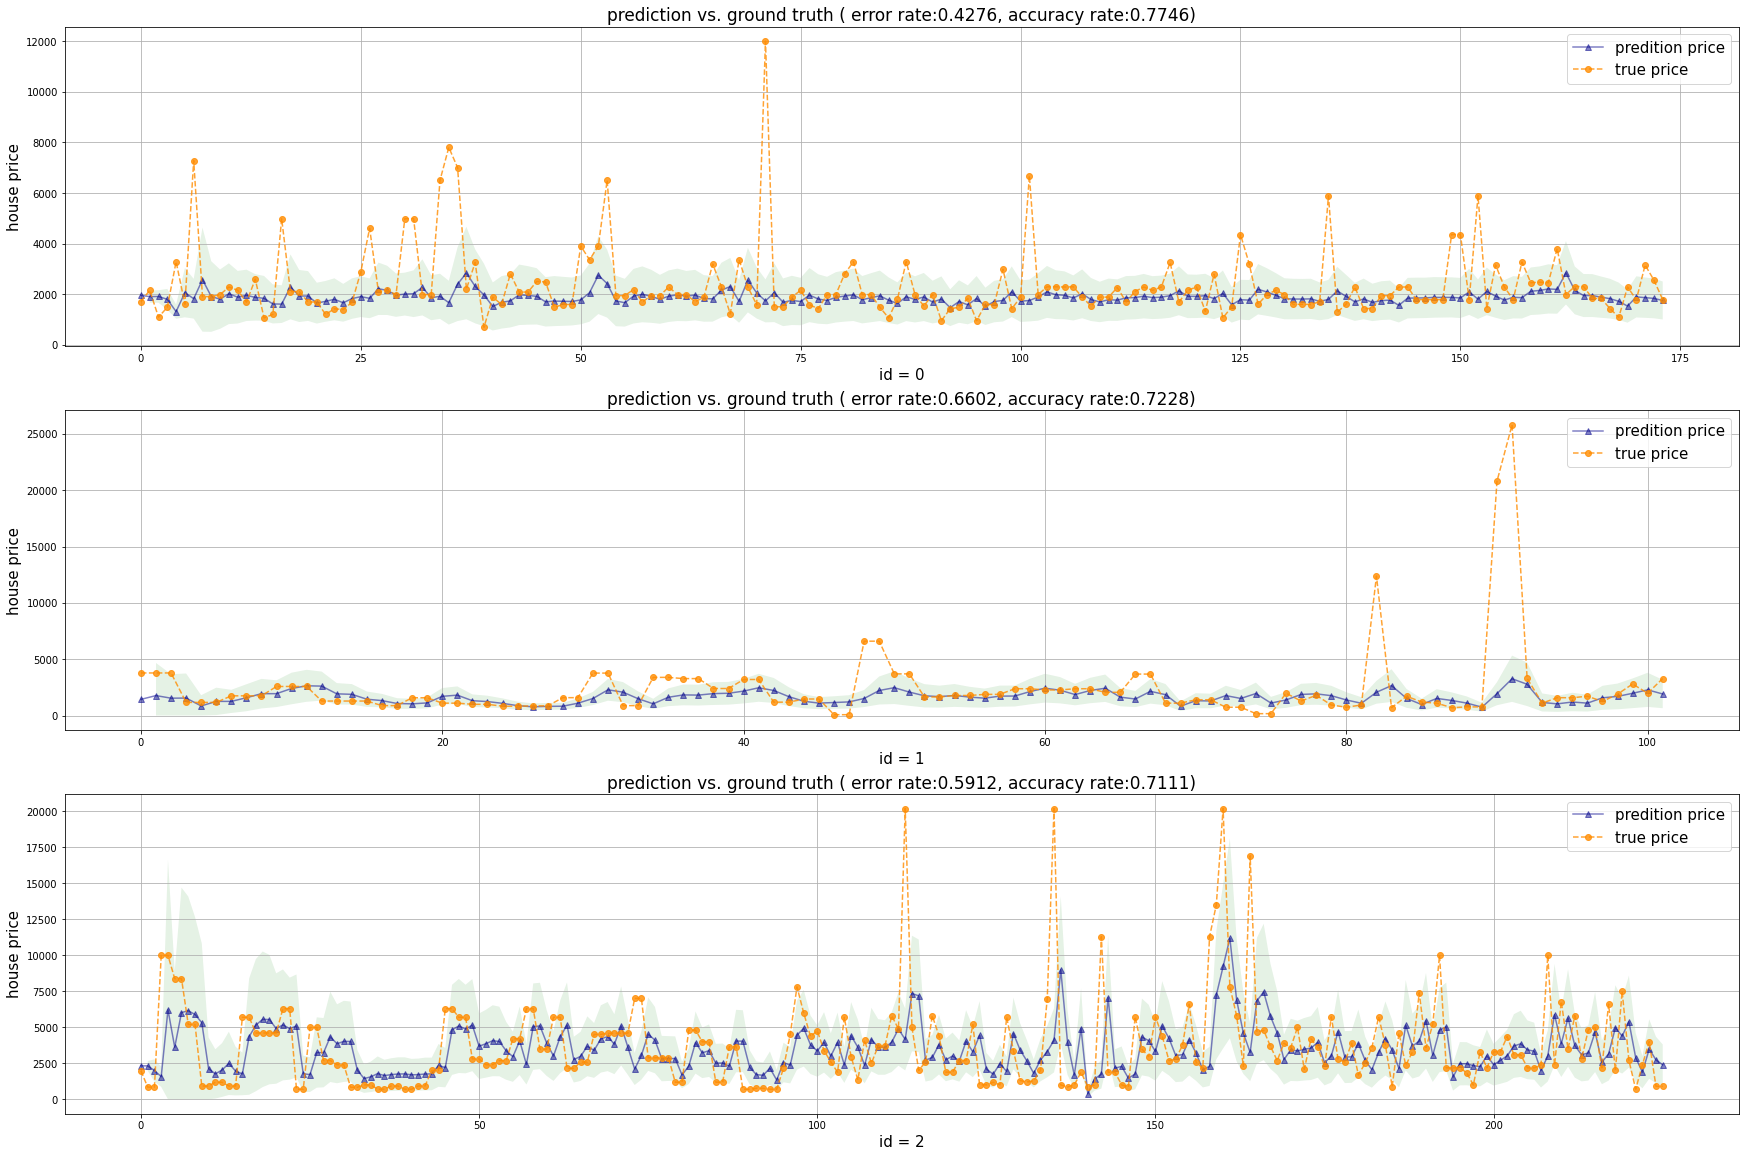

In [30]:
member_result_accuracy = sorted(zip(list(accuracy_rate.values()), member_used), key=lambda x: x[0], reverse=True)

fig, ax = plt.subplots(ncols=1, nrows=3,figsize=(30,20))
for i in range(3):
  id = member_result_accuracy[i][1]
  ax[i].plot(range(len(all_y[id]['y_true'])), all_y[id]['y_pred']['lstm'],'^-', color='darkblue',alpha=0.5)
  ax[i].plot(range(len(all_y[id]['y_true'])), all_y[id]['y_true'],'o--', color='darkorange',alpha=0.8)
  ax[i].set_title('prediction vs. ground truth ( error rate:'+ str(round(np.mean(error_rate[id]),4))+', accuracy rate:'+str(round(member_result_accuracy[i][0], 4))+')',fontsize = 17)
  ax[i].set_ylabel('house price',fontsize=15) 
  ax[i].set_xlabel('id = ' + str(i),fontsize=15)
  ax[i].legend(['predition price','true price'],fontsize=15) 
  ax[i].fill_between(range(1, len(all_y[id]['y_true'])),high_low[id]['low'],high_low[id]['high'],facecolor='green',alpha=0.1)
plt.savefig('pred_truth_top3_accuracy.png')

### Mean squared error & Mean absolute error



In [ ]:
def performance_loss_mae(valid_test, model_name, loss_mae):
  tmp = []
  for i in member_used:
    tmp.append(performance[i][valid_test][model_name][loss_mae])
  return tmp

In [ ]:
result_loss = {}
result_mae = {}
for valid_test in ['validation', 'test']:
  for model_name in ['conv_model','lstm','multi_step_dense_model']:
    result_loss[valid_test +'_'+ model_name] = performance_loss_mae(valid_test, model_name, 0)
    result_mae[valid_test +'_'+ model_name] = performance_loss_mae(valid_test, model_name, 1)

In [ ]:
def plot_loss_mae(loss_mae, valid_test, tmp):
  global count, count_1, count_2, count_3
  if loss_mae == 0: # loss
    if valid_test == 0: # valid
      ax[loss_mae][valid_test].plot(range(len(tmp)),tmp,'o-', color=color_loss[count])
      if count == 0:
        ax[loss_mae][valid_test].set_title('validation_loss',fontsize = 15)
        ax[loss_mae][valid_test].set_ylabel('loss',fontsize=15) 
        ax[loss_mae][valid_test].set_xlabel('member id',fontsize=15)
      count += 1
      if count == 3:
        ax[loss_mae][valid_test].legend(['validation_conv_model_loss','validation_lstm_loss','validation_multi_step_dense_model_loss'])

    elif valid_test == 1: # test
      ax[loss_mae][valid_test].plot(range(len(tmp)),tmp,'*-', color=color_loss[count_1])
      if count_1 == 0:
        ax[loss_mae][valid_test].set_title('test_loss',fontsize = 15)
        ax[loss_mae][valid_test].set_ylabel('loss',fontsize=15) 
        ax[loss_mae][valid_test].set_xlabel('member id',fontsize=15)
      count_1 += 1
      if count_1 == 3:
        ax[loss_mae][valid_test].legend(['test_conv_model_loss','test_lstm_loss','test_multi_step_dense_model_loss'])

  elif loss_mae == 1: # mae
    if valid_test == 0: # valid
      ax[loss_mae][valid_test].plot(range(len(tmp)),tmp,'o-', color=color_mae[count_2])
      if count_2 == 0:
        ax[loss_mae][valid_test].set_title('validation_MAE',fontsize = 15)
        ax[loss_mae][valid_test].set_ylabel('MAE',fontsize=15)
        ax[loss_mae][valid_test].set_xlabel('member id',fontsize=15) 
      count_2 += 1
      if count_2 == 3:
        ax[loss_mae][valid_test].legend(['validation_conv_model_MAE','validation_lstm_MAE','validation_multi_step_dense_model_MAE'])

    elif valid_test == 1: # test
      ax[loss_mae][valid_test].plot(range(len(tmp)),tmp,'*-', color=color_mae[count_3])
      if count_3 == 0:
        ax[loss_mae][valid_test].set_title('test_MAE',fontsize = 15)
        ax[loss_mae][valid_test].set_ylabel('MAE',fontsize=15) 
        ax[loss_mae][valid_test].set_xlabel('member id',fontsize=15)
      count_3 += 1
      if count_3 == 3:
        ax[loss_mae][valid_test].legend(['test_conv_model_MAE','test_lstm_MAE','test_multi_step_dense_model_MAE'])


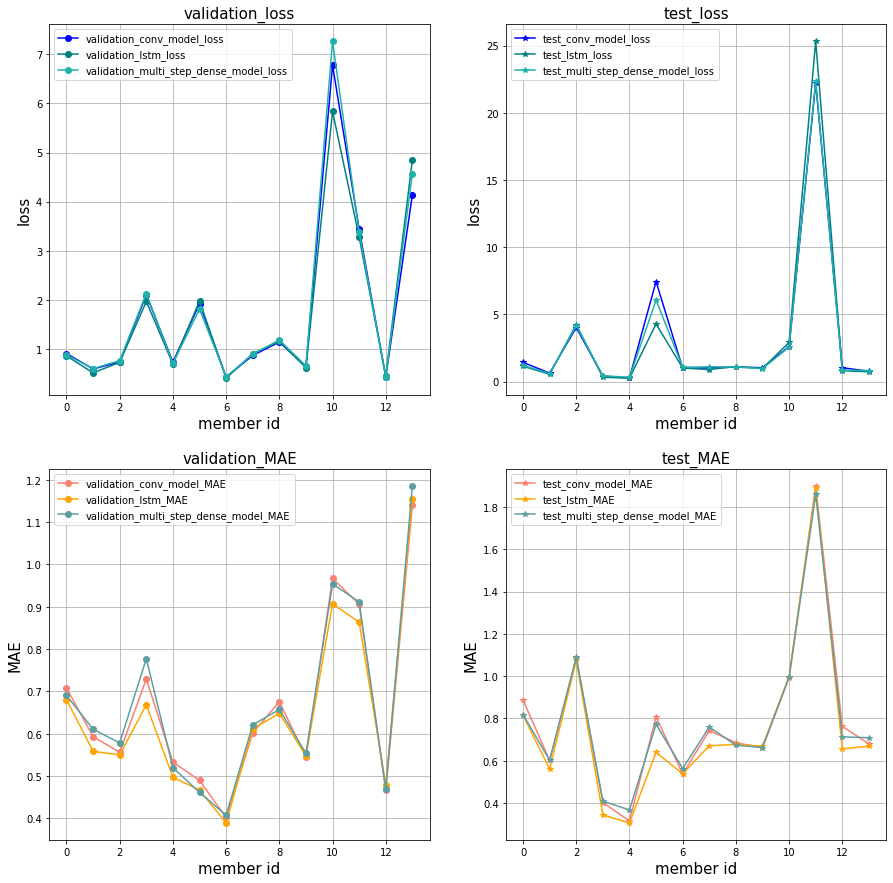

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(15,15))
color_loss = ['blue','teal','lightseagreen']
color_mae = ['salmon','orange','cadetblue']
count = 0
count_1 = 0
count_2 = 0
count_3 = 0
for j in result_loss:
  if 'validation' in j:
    plot_loss_mae(0, 0, result_loss[j])
    plot_loss_mae(1, 0, result_mae[j])
  elif 'test' in j:  
    plot_loss_mae(0, 1, result_loss[j])
    plot_loss_mae(1, 1, result_mae[j])

plt.savefig('loss_mae.png')

In [ ]:
test_mean_loss = []
valid_mean_loss = []
test_mean_mae = []
valid_mean_mae = []
for i in result_loss:
  if 'test' in i:
    test_mean_loss.append(np.mean(result_loss[i]))
    test_mean_mae.append(np.mean(result_mae[i]))
  else:
    valid_mean_loss.append(np.mean(result_loss[i]))
    valid_mean_mae.append(np.mean(result_mae[i]))

In [ ]:
def plot_average(line_style, tmp, color):
  plt.plot(['conv_model','lstm_model','multi_step_dense_model'], tmp, line_style, color=color)
  for i in range(len(tmp)):
    plt.text(i, tmp[i], round(tmp[i]+0.1,4), ha='center', va= 'bottom',fontsize=10)  

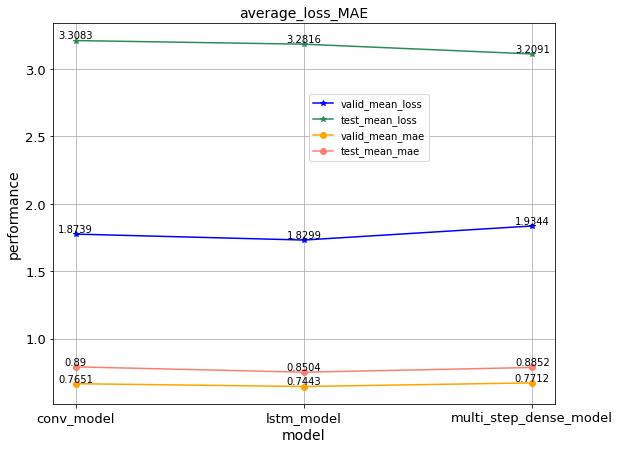

In [ ]:
plt.figure(figsize=(9,7))
plot_average('*-', valid_mean_loss, 'blue')
plot_average('*-', test_mean_loss, 'seagreen')
plot_average('o-', valid_mean_mae, 'orange')
plot_average('o-', test_mean_mae, 'salmon')

plt.title('average_loss_MAE',fontsize = 14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('model',fontsize=14)
plt.ylabel('performance',fontsize=14)
plt.legend(['valid_mean_loss','test_mean_loss','valid_mean_mae','test_mean_mae'],bbox_to_anchor=(0.5, 0.625, 0.533, 0.49))
plt.savefig('average_loss_mae.png')